In [12]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy, relu
import time
import copy

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

## Data + Utils

In [13]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [14]:
def compute_objective(model, X, y):
    """ Compute the multinomial logistic loss. 
        model is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = model(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(model, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    is_train = model.training  # if True, model is in training mode
    model.eval()  # use eval mode for accuracy
    score = model(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(model, verbose=False):
    is_train = model.training  # if True, model is in training mode
    model.eval()  # switch to eval mode
    train_loss = compute_objective(model, X_train, y_train)
    test_loss = compute_objective(model, X_test, y_test)
    train_accuracy = compute_accuracy(model, X_train, y_train)
    test_accuracy = compute_accuracy(model, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [15]:
def compute_local_smoothness(model, X, y, learning_rate, batch_size):
    
    # Compute the full batch gradient
    model.eval()
    objective1 = compute_objective(model, X, y) 
    batch_gradient_1 = torch.autograd.grad(outputs=objective1, inputs=model.parameters())
    
    # Copy of model to update and measure local smoothness
    model2 = copy.deepcopy(model)
    
    # Update model2 with a single stochastic gradient
    idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
    model2.train()  # make sure we are in train mode
    # compute the objective. 
    stochastic_objective = compute_objective(model2, X[idxs], y[idxs]) 
    # compute the gradient using automatic differentiation
    stochastic_gradient = torch.autograd.grad(
        outputs=stochastic_objective, inputs=model2.parameters())
    # perform SGD update inplace
    with torch.no_grad():
        for (w, g) in zip(model2.parameters(), stochastic_gradient):
            w -= learning_rate * g
            
    # Compute full batch gradient for model2
    model2.eval()
    objective2 = compute_objective(model2, X, y) 
    batch_gradient_2 = torch.autograd.grad(outputs=objective2, inputs=model2.parameters())
    
    gradient_diff_norm = np.linalg.norm([
        torch.norm((g1 - g2).view(-1)).item() for (g1, g2) in zip(batch_gradient_1, batch_gradient_2)
    ])
    parameter_diff_norm = np.linalg.norm([
        torch.norm((w1 - w2).view(-1)).item() for (w1, w2) in zip(model.parameters(), model2.parameters())
    ])
    return gradient_diff_norm / parameter_diff_norm
    

In [16]:
def minibatch_sgd_one_pass(model, X, y, learning_rate, batch_size, verbose=False):
    model.train()
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        model.train()  # make sure we are in train mode
        # compute the objective. 
        objective = compute_objective(model, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
    return model

## Part 1

In [24]:
class ConvNet_NoBN(torch.nn.Module): # Hard-coded for 784 dimensional input, 10 outputs
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fc = torch.nn.Linear(7*7*32, 10)  
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv_ensemble_1(x)
        out = self.conv_ensemble_2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
class ConvNet_BN(torch.nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(16))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(32))
        self.fc = torch.nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv_ensemble_1(x)
        out = self.conv_ensemble_2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    

In [57]:
# no batch norm
model = ConvNet_NoBN()


learning_rate = 0.04

logs = []
curvs = [compute_local_smoothness(model, X_train, y_train, learning_rate, batch_size)]

logs.append(compute_logs(model, verbose=True))

batch_size = 32

for _ in range(10):  # run multiple passes because our sub-sampled dataset is too small
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                   batch_size=batch_size, verbose=False)
    logs.append(compute_logs(model, verbose=True))
    curvs.append(compute_local_smoothness(model, X_train, y_train, learning_rate, batch_size))

logs_nobn = np.asarray(logs)
curvs_nobn = np.asarray(curvs)

Train Loss = 2.309, Train Accuracy = 0.041, Test Loss = 2.312, Test Accuracy = 0.045
Train Loss = 0.564, Train Accuracy = 0.789, Test Loss = 0.585, Test Accuracy = 0.790
Train Loss = 0.443, Train Accuracy = 0.842, Test Loss = 0.497, Test Accuracy = 0.828
Train Loss = 0.381, Train Accuracy = 0.865, Test Loss = 0.462, Test Accuracy = 0.835
Train Loss = 0.351, Train Accuracy = 0.881, Test Loss = 0.459, Test Accuracy = 0.852
Train Loss = 0.301, Train Accuracy = 0.896, Test Loss = 0.437, Test Accuracy = 0.859
Train Loss = 0.321, Train Accuracy = 0.887, Test Loss = 0.467, Test Accuracy = 0.848
Train Loss = 0.272, Train Accuracy = 0.904, Test Loss = 0.428, Test Accuracy = 0.862
Train Loss = 0.238, Train Accuracy = 0.919, Test Loss = 0.397, Test Accuracy = 0.868
Train Loss = 0.228, Train Accuracy = 0.918, Test Loss = 0.409, Test Accuracy = 0.865
Train Loss = 0.230, Train Accuracy = 0.920, Test Loss = 0.439, Test Accuracy = 0.858


In [59]:
# with batch norm
model = ConvNet_BN()


learning_rate = 0.04

logs = []
curvs = [compute_local_smoothness(model, X_train, y_train, learning_rate, batch_size)]

logs.append(compute_logs(model, verbose=True))

batch_size = 10

for _ in range(10):  # run multiple passes because our sub-sampled dataset is too small
    model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                   batch_size=batch_size, verbose=False)
    logs.append(compute_logs(model, verbose=True))
    curvs.append(compute_local_smoothness(model, X_train, y_train, learning_rate, batch_size))

logs_bn = np.asarray(logs)
curvs_bn = np.asarray(curvs)

Train Loss = 2.314, Train Accuracy = 0.162, Test Loss = 2.322, Test Accuracy = 0.151
Train Loss = 0.470, Train Accuracy = 0.850, Test Loss = 0.622, Test Accuracy = 0.820
Train Loss = 0.288, Train Accuracy = 0.902, Test Loss = 0.492, Test Accuracy = 0.856
Train Loss = 0.203, Train Accuracy = 0.930, Test Loss = 0.457, Test Accuracy = 0.864
Train Loss = 0.173, Train Accuracy = 0.943, Test Loss = 0.460, Test Accuracy = 0.867
Train Loss = 0.134, Train Accuracy = 0.954, Test Loss = 0.459, Test Accuracy = 0.870
Train Loss = 0.141, Train Accuracy = 0.952, Test Loss = 0.541, Test Accuracy = 0.858
Train Loss = 0.102, Train Accuracy = 0.968, Test Loss = 0.516, Test Accuracy = 0.863
Train Loss = 0.097, Train Accuracy = 0.967, Test Loss = 0.516, Test Accuracy = 0.861
Train Loss = 0.058, Train Accuracy = 0.982, Test Loss = 0.540, Test Accuracy = 0.872
Train Loss = 0.064, Train Accuracy = 0.981, Test Loss = 0.525, Test Accuracy = 0.866


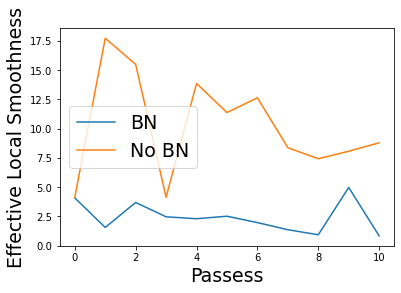

In [60]:
plt.plot(curvs_bn, label='BN')
plt.plot(curvs_nobn, label='No BN')
plt.xlabel('Passess', fontsize=19)
plt.ylabel('Effective Local Smoothness', fontsize=19)
plt.legend(fontsize=19)

Text(0.5, 1.0, 'Test Accuracy')

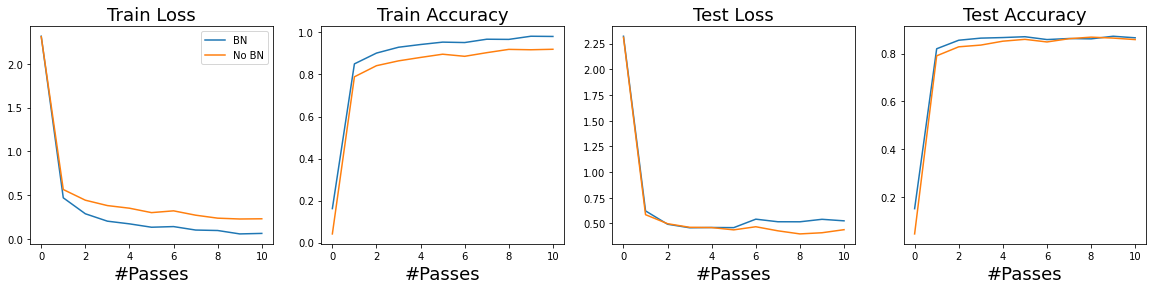

In [61]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))
for logs, name in zip([logs_bn, logs_nobn], ['BN', 'No BN']):
    ax[0].plot(logs[:, 0], label=name)
    ax[2].plot(logs[:, 2], label=name)
    

    ax[1].plot(logs[:, 1], label=name)
    ax[3].plot(logs[:, 3], label=name)
    
ax[0].legend()
for a in ax:
    a.set_xlabel('#Passes', fontsize=18)


ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Train Accuracy', fontsize=18)
ax[2].set_title('Test Loss', fontsize=18)
ax[3].set_title('Test Accuracy', fontsize=18)


As you can see in the local effective smoothness graph, we have more lower local effective smoothness with bachnorm, therefore the learning rate can be larger than without bachnorm (1/L, where L is L-smooth function). 

# Part 2

In [1]:
# Download Text REtrietest Conference (TREC) Question Classifiction data (https://cogcomp.seas.upenn.edu/Data/QA/QC/)
import requests
import numpy as np

# Training Data
URL = "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_1000.label"
TREC_train_data = str(requests.get(URL).content).split("\\n")
train_label = []
train_input = []
for i, t in enumerate(TREC_train_data[:-1]):
    if i ==0:
        train_label.append(t.split(":")[0][2:])
    else:
      train_label.append(t.split(":")[0])
    train_input.append(" ".join(t.split(":")[1].split(" ")[1:]))

train={"input":train_input, "label":train_label}

# Test Data
URL = "https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label"
TREC_test_data = str(requests.get(URL).content).split("\\n")
test_label = []
test_input = []
for i, t in enumerate(TREC_test_data[:-1]):
    if i ==0:
        test_label.append(t.split(":")[0][2:])
    else:
      test_label.append(t.split(":")[0])
    test_input.append(" ".join(t.split(":")[1].split(" ")[1:]))
test={"input":test_input, "label":test_label}

print("Example of Input/Label")
print("Input:", train_input[1])
print("Label:", train_label[1])

np.unique(list(train['label'])+list(test['label']))

Example of Input/Label
Input: What films featured the character Popeye Doyle ?
Label: ENTY


array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype='<U4')

In [2]:
# Change string label to integer label
from sklearn import preprocessing
import numpy as np

le = preprocessing.LabelEncoder()
le.fit(train['label']+test['label'])
train['categorical_label'] = le.transform(train['label'])
test['categorical_label'] = le.transform(test['label'])
print("New Label:", train['categorical_label'][1])
print("Nclasses:", len(np.unique(list(train['categorical_label'])+list(test['categorical_label']))))

New Label: 2
Nclasses: 6


In [3]:
# Tokenize the data
from docopt import docopt
import spacy
spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

#  extract features training_data
train_input_vec = [[nlp(v).vector] for v in train['input']]  
test_input_vec = [[nlp(v).vector] for v in test['input']]

print("Length of One word Vector:", len(train_input_vec[0][0]))
print("Word Vector Example: ", train_input_vec[1])

Length of One word Vector: 96
Word Vector Example:  [array([ 0.05669461,  0.14431228, -0.09996024,  0.24405436,  0.17144223,
       -0.00698099,  0.5538776 , -0.04801345,  0.10472064, -0.0724301 ,
        0.46154702,  0.6193586 , -0.2742111 , -0.36640358, -0.41472915,
       -0.3367687 , -0.80017823,  0.01405566,  0.37896937, -0.26699197,
        0.06921677,  0.1596782 ,  0.4810588 , -0.59376097,  0.54818946,
        0.47652596,  0.55965155, -0.21928822,  0.08473992,  0.5288323 ,
       -0.47222984, -0.03617568, -0.03886646, -0.4117626 , -0.05733662,
        0.00477944, -0.20796035,  0.08200786,  0.00801046,  0.29752997,
       -0.22893679,  0.33473495,  0.16553667, -0.12274137, -0.3228015 ,
       -0.28731245,  0.04599106,  0.05031565,  0.18770975,  0.06129264,
       -0.1034981 , -0.06582367,  0.57545704,  0.15352717, -0.22472565,
       -0.04059392,  0.11420984,  0.40521163,  0.3088222 , -0.2678545 ,
       -0.24282809,  0.06950298, -0.37544304, -0.21284604,  0.14027752,
       -0.0

In [4]:
from torch import nn
import torch
from torch import optim
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, nclasses:int, linear_dimension:int,kernel_size, padding,conv_stride,  window_size: int = 16, embedding_dim: int = 16,
    filter_multiplier: int = 64):
        super(SimpleCNN, self).__init__()
        self.simpleconv = nn.Conv2d(in_channels=1, out_channels=filter_multiplier, stride=CONV_STRIDE, kernel_size=kernel_size, padding=padding)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=CONV_STRIDE, padding=padding)
        self.linear = nn.Linear(linear_dimension, out_features=nclasses)
        self.softmax = nn.LogSoftmax(1)
    
    def forward(self, x, **kwargs): # shape: (batch, 16, 96)
        # input x is already embedding vectors from spaCy
        # set the channel dim to a new dimension that’s just 1
        x = torch.transpose(x, 1, 2) # (batch, 1, 96)
        x = torch.unsqueeze(x, 1) # (batch, 1, 96, 1)
        x = self.simpleconv(x) # (batch, 64, 48, 1)
        x = self.maxpool(x) # (batch, 64, 24, 1) 
        F.relu(x) # non-linear function to activate the neurons
        x = x.flatten(start_dim=1) # (batch, 1536)
        x = self.linear(x)
        F.relu(x)
        x = self.softmax(x)
        return x

In [5]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def run_cnn_text(num_classes, batch_size, learning_rate, num_epochs, CONV_STRIDE, linear_dimention, kernel_size, padding):
  model = SimpleCNN(num_classes, linear_dimention, kernel_size, padding, CONV_STRIDE) 
  # Create Dataloaders
  train_inputs_tensor, test_inputs_tensor, train_label_tensor, test_label_tensor = tuple(torch.tensor(data) for data in[train_input_vec, test_input_vec, train['categorical_label'], test['categorical_label']])
  # Create DataLoader for training data
  train_data = TensorDataset(train_inputs_tensor, train_label_tensor)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create DataLoader for testidation data
  test_data = TensorDataset(test_inputs_tensor, test_label_tensor)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
  lossfn = nn.NLLLoss()
  for epoch in range(num_epochs):
    running_loss = 0.
    for i, batch in enumerate(train_dataloader): # create a new generator every epoch
      input, label  = b_input_ids, b_labels = tuple(t for t in batch)
      optimizer.zero_grad()
      outputs = model(input)
      loss = lossfn(outputs, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()


  model = model.eval()
  num_correct = 0
  num_examples = 0
  # Check accuracy
  for i, batch in enumerate(test_dataloader):
    y, target = batch
    output = model(y)
    y_pred = []
    for o in output:
      y_pred.append(torch.max(o, -1).indices.item()) # Choose class with highest option
    y_pred = torch.FloatTensor(y_pred)
    correct = torch.eq(torch.round(y_pred).type(target.type()), target).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
  print("Accuracy: ",  num_correct / num_examples)
  return(num_correct / num_examples)

In [6]:
num_classes = 6 
batch_size = 32
learning_rate = 0.1
num_epochs = 50
CONV_STRIDE = 2
linear_dimension = 1600
kernel_size = 2
padding = 1
linear_dimension = 1536
kernel_size = 3
padding = 1

conv_stride = [1, 5, 10, 30, 100, 500]
test_acc_mean = []
for c in conv_stride:
    test_accuracy = []
    for i in range(5):
        test_accuracy.append(run_cnn_text(num_classes, batch_size, learning_rate, num_epochs, c, linear_dimension, kernel_size, padding))
    test_acc_mean.append(np.mean(test_accuracy))
    print(f"Convoluation Stride = {c}: {np.mean(test_accuracy)}")

/var/folders/__/vmn4s2rd6755rfl9h22x7pzr0000gn/T/ipykernel_25431/21429711.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_inputs_tensor, test_inputs_tensor, train_label_tensor, test_label_tensor = tuple(torch.tensor(data) for data in[train_input_vec, test_input_vec, train['categorical_label'], test['categorical_label']])


Accuracy:  0.682
Accuracy:  0.672
Accuracy:  0.642
Accuracy:  0.67
Accuracy:  0.686
Convoluation Stride = 1: 0.6704
Accuracy:  0.666
Accuracy:  0.664
Accuracy:  0.67
Accuracy:  0.648
Accuracy:  0.646
Convoluation Stride = 5: 0.6588
Accuracy:  0.674
Accuracy:  0.654
Accuracy:  0.666
Accuracy:  0.648
Accuracy:  0.626
Convoluation Stride = 10: 0.6536000000000001
Accuracy:  0.678
Accuracy:  0.656
Accuracy:  0.648
Accuracy:  0.662
Accuracy:  0.67
Convoluation Stride = 30: 0.6628000000000001
Accuracy:  0.69
Accuracy:  0.66
Accuracy:  0.678
Accuracy:  0.644
Accuracy:  0.634
Convoluation Stride = 100: 0.6612
Accuracy:  0.668
Accuracy:  0.636
Accuracy:  0.66
Accuracy:  0.64
Accuracy:  0.664
Convoluation Stride = 500: 0.6536000000000001


Text(0, 0.5, 'Accuracy')

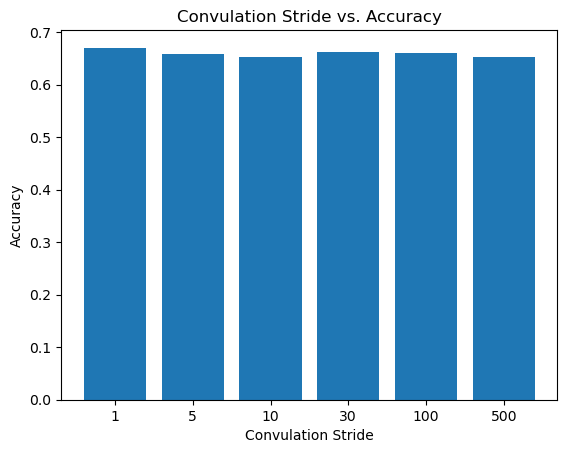

In [9]:
import matplotlib.pylab as plt
plt.bar([str(c) for c in conv_stride], test_acc_mean)
plt.title("Convulation Stride vs. Accuracy")
plt.xlabel("Convulation Stride")
plt.ylabel("Accuracy")


# 3. BONUS

In [34]:
class ConvNet_NoBN_stride(torch.nn.Module): # Hard-coded for 784 dimensional input, 10 outputs
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=2),
            torch.nn.ReLU())
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=2),
            torch.nn.ReLU())
        self.fc = torch.nn.Linear(32*7*7, 10)  
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.conv_ensemble_1(x)
        out = self.conv_ensemble_2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

In [35]:
import time

model = ConvNet_NoBN_stride()

lr = 0.04
batch_size = 32
epochs = 10

logs_nopooling = []
start = time.time()
for _ in range(epochs):
    print(f"Iteration {_+1}")
    logs_nopooling.append(compute_logs(model, verbose=True)) 
    model = minibatch_sgd_one_pass(model, X_train, y_train, lr, batch_size, verbose=False)

print("Time taken:", round(time.time()-start,2))

Iteration 1
Train Loss = 2.280, Train Accuracy = 0.140, Test Loss = 2.280, Test Accuracy = 0.142
Iteration 2
Train Loss = 0.601, Train Accuracy = 0.784, Test Loss = 0.632, Test Accuracy = 0.765
Iteration 3
Train Loss = 0.492, Train Accuracy = 0.824, Test Loss = 0.549, Test Accuracy = 0.803
Iteration 4
Train Loss = 0.495, Train Accuracy = 0.814, Test Loss = 0.583, Test Accuracy = 0.782
Iteration 5
Train Loss = 0.393, Train Accuracy = 0.862, Test Loss = 0.479, Test Accuracy = 0.828
Iteration 6
Train Loss = 0.355, Train Accuracy = 0.874, Test Loss = 0.460, Test Accuracy = 0.841
Iteration 7
Train Loss = 0.335, Train Accuracy = 0.883, Test Loss = 0.471, Test Accuracy = 0.832
Iteration 8
Train Loss = 0.364, Train Accuracy = 0.864, Test Loss = 0.503, Test Accuracy = 0.826
Iteration 9
Train Loss = 0.335, Train Accuracy = 0.878, Test Loss = 0.486, Test Accuracy = 0.830
Iteration 10
Train Loss = 0.268, Train Accuracy = 0.907, Test Loss = 0.444, Test Accuracy = 0.849
Time taken: 26.18


In [27]:
model = ConvNet_NoBN()

lr = 0.04
batch_size = 32
epochs = 10

logs_pooling = []
start = time.time()
for _ in range(epochs):
    print(f"Iteration {_+1}")
    logs_pooling.append(compute_logs(model, verbose=True)) 
    model = minibatch_sgd_one_pass(model, X_train, y_train, lr, batch_size, verbose=False)

print("Time taken:", round(time.time()-start,2))

Iteration 1
Train Loss = 2.346, Train Accuracy = 0.080, Test Loss = 2.351, Test Accuracy = 0.079
Iteration 2
Train Loss = 0.564, Train Accuracy = 0.800, Test Loss = 0.586, Test Accuracy = 0.791
Iteration 3
Train Loss = 0.459, Train Accuracy = 0.830, Test Loss = 0.525, Test Accuracy = 0.805
Iteration 4
Train Loss = 0.388, Train Accuracy = 0.861, Test Loss = 0.467, Test Accuracy = 0.835
Iteration 5
Train Loss = 0.399, Train Accuracy = 0.848, Test Loss = 0.532, Test Accuracy = 0.807
Iteration 6
Train Loss = 0.322, Train Accuracy = 0.886, Test Loss = 0.451, Test Accuracy = 0.848
Iteration 7
Train Loss = 0.300, Train Accuracy = 0.890, Test Loss = 0.457, Test Accuracy = 0.855
Iteration 8
Train Loss = 0.326, Train Accuracy = 0.881, Test Loss = 0.493, Test Accuracy = 0.833
Iteration 9
Train Loss = 0.244, Train Accuracy = 0.919, Test Loss = 0.413, Test Accuracy = 0.865
Iteration 10
Train Loss = 0.239, Train Accuracy = 0.919, Test Loss = 0.415, Test Accuracy = 0.860
Time taken: 127.0


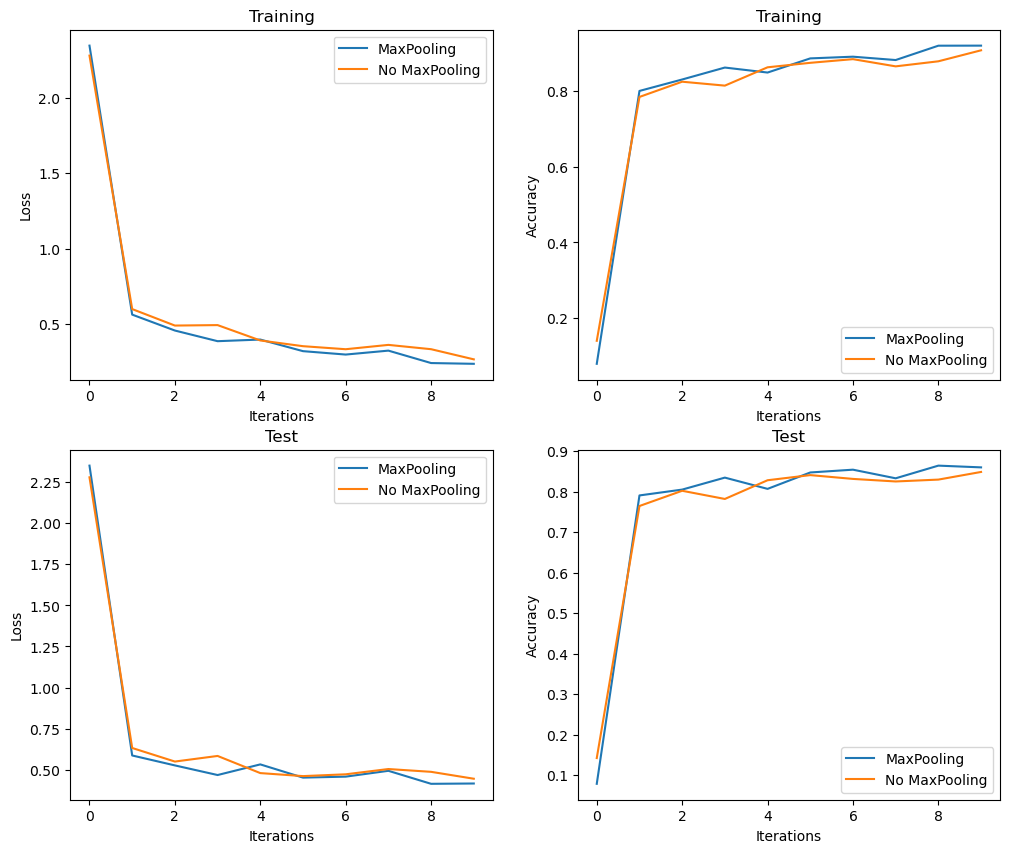

In [36]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,10)
for a in ax.flatten(): a.set_xlabel("Iterations")
for a in ax: a[0].set_ylabel("Loss")
for a in ax: a[1].set_ylabel("Accuracy")
for a in ax[0,:]: a.set_title("Training")
for a in ax[1,:]: a.set_title("Test")

names = zip([logs_pooling, logs_nopooling], ["MaxPooling", "No MaxPooling"])
for log, label in names:
    log = np.asarray(log)
    ax[0,0].plot(log[:,0], label = label)
    ax[0,0].legend()
    ax[0,1].plot(log[:,1], label = label)
    ax[0,1].legend()
    ax[1,0].plot(log[:,2], label = label)
    ax[1,0].legend()
    ax[1,1].plot(log[:,3], label = label)
    ax[1,1].legend()